In [1]:
import pickle
import itertools
import open3d as o3d
import numpy as np
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

import glob, pickle, os

import numpy as np
import scipy as sp
import pandas as pd

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly
import plotly.graph_objects as go
import plotly.io as pio
from mayavi import mlab
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
inds = ["exp2021_005_GmJMC112_01_MVI_01",
       "exp2021_005_GmJMC112_01_MVI_02",
       "exp2021_005_GmJMC112_01_MVI_04"]

In [20]:
def make_path(ind):
    curves_list = ["curves/"+ind+"_opt_curves_bottom.pkl",
                   "curves/"+ind+"_opt_curves_middle.pkl",
                   "curves/"+ind+"_opt_curves_upper.pkl"]
    inner_para_file = "../view_mats/"+ind+"_view_mat/inner_para.csv"
    return curves_list, inner_para_file
    
def load_curves(path):
    with open(path, "rb") as pickle_file:
        mc = pickle.load(pickle_file)
        #temp=[]
        #for curve in mc:
        #    temp += curve
        #temp = [curve for curve in temp if len(curve) != 0]
    return mc

def load_innner_para(path):
    return np.loadtxt(inner_para_file, delimiter=",")

def make_nums(ind):
    view_mat_folder = "../view_mats/"+ind+"_view_mat/"
    view_mat_file_list = glob.glob(view_mat_folder+"[0-9]*csv")
    num_list = []
    for view_mat in view_mat_file_list:
        num_list.append(int(view_mat.split("\\")[-1].split(".")[0]))
    return num_list

def load_outer_para(ind, cam_num):
    view_mat_file_path = "../view_mats/"+ind+"_view_mat/"+str(cam_num)+".csv"
    Rt = np.loadtxt(view_mat_file_path, delimiter=",")
    Rt = np.linalg.pinv(Rt)[0:3]
    return Rt

def get_2d_coord(mc, P):
    coord = []
    for i in range(len(mc)):
        s_curve = np.concatenate([mc[i], np.ones((len(mc[i]), 1))],axis=1)
        mc_0_coord = (P @ s_curve.T).T
        mc_0_coord = np.array([mc_0_coord[:,0]/mc_0_coord[:,2],mc_0_coord[:,1]/mc_0_coord[:,2]]).T
        mc_0_coord = np.round(mc_0_coord).astype("int")
        coord.append(mc_0_coord)
    return coord

def is_point_inside_image(point, h, w):
    x, y = point
    if x < 0 or x >= w or y < 0 or y >= h:
        return False
    else:
        return True

def get_dilation_coord(coord):
    leaf_list = []
    kernel = np.ones((5,5),np.uint8)
    for co in coord:
        zero_img = np.zeros((3456, 5184))
        pre_inside_points = np.array([p for p in co if is_point_inside_image(p, 3456, 5184)])
        zero_img[pre_inside_points[:,1], pre_inside_points[:,0]] = 255
        #zero_img[co[:,1], co[:,0]] = 255
        dilation = cv2.dilate(zero_img, kernel, iterations =2)
        dil_coord = np.where(dilation == 255)
        dil_coord = np.array(dil_coord).T
        #inside_points = np.array([p for p in dil_coord if is_point_inside_image(p, 3456, 5184)])
        leaf_list.append(dil_coord)
    return leaf_list

def make_overlap_img(ind, cam_num, curves_path, leaf_list):
    ori_img_path = "../images/"+ind+"/"+str(cam_num)+".JPG"
    output_folder = "output_images_test_2/"+curves_path.split("/")[-1].split(".")[0]+"/overlap/"
    os.makedirs(output_folder, exist_ok=True)
    output_file = output_folder + "v_" + str(cam_num) + ".jpg"
    ori_img = cv2.imread(ori_img_path)
    for i in range(len(leaf_list)):
        color_tuple = plt.cm.tab20(i)
        color = np.array(color_tuple)[0:3]
        ori_img[leaf_list[i][:,0], leaf_list[i][:,1],:] = color.reshape(1,-1) * 255
    cv2.imwrite(output_file, ori_img)

def make_recon_img(ind, cam_num, curves_path, leaf_list):
    #ori_img_path = "../images/"+ind+"/"+str(cam_num)+".JPG"
    ori_img = np.ones((3456, 5184, 3))*255
    output_folder = "output_images_test_2/"+curves_path.split("/")[-1].split(".")[0]+"/reconstruction/"
    os.makedirs(output_folder, exist_ok=True)
    output_file = output_folder + "v_" + str(cam_num) + ".jpg"
    #ori_img = cv2.imread(ori_img_path)
    for i in range(len(leaf_list)):
        color_tuple = plt.cm.tab20(6)
        color = np.array(color_tuple)[0:3]
        color = color[::-1]
        ori_img[leaf_list[i][:,0], leaf_list[i][:,1],:] = color.reshape(1,-1) * 255
    cv2.imwrite(output_file, ori_img.astype(np.uint8))

In [19]:
color[::-1]

array([0.15686275, 0.15294118, 0.83921569])

In [17]:
color_tuple = plt.cm.tab20(6)
color = np.array(color_tuple)[0:3]
color.reshape(1,-1) * 255

array([[214.,  39.,  40.]])

In [21]:
ind = inds[2]
curves_list, inner_para_file = make_path(ind)
A = load_innner_para(inner_para_file)
curve = curves_list[2]
nums = make_nums(ind)
mc = load_curves(curve)
mc = [c for c in mc[86] if len(c) != 0]
for i in nums:
    Rt = load_outer_para(ind, 13)
    P = A@Rt
    coord = get_2d_coord(mc, P)
    leaf_list = get_dilation_coord(coord)
    make_recon_img(ind, 13, curve, leaf_list)
    break

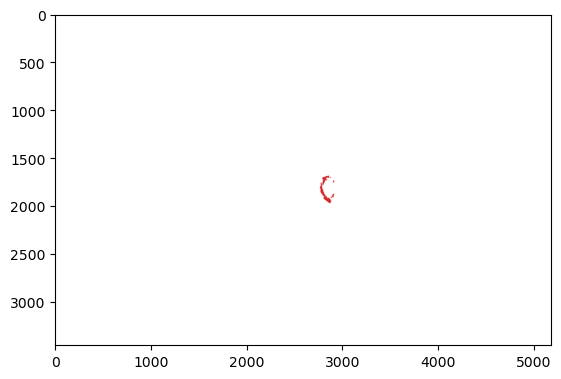

In [15]:
plt.imshow(img.astype(np.uint8))

In [14]:
np.unique(img)

array([ 39.,  40., 214., 255.])

In [89]:
leaf_list[0][0]

array([1796, 3170], dtype=int64)

In [71]:
def is_point_inside_image(point, h, w):
    x, y = point
    if x < 0 or x >= w or y < 0 or y >= h:
        return False
    else:
        return True

h= 20
w= 50
points = np.array([[10, 20], [-12, 3], [30, 40], [h+7, 100]])
inside_points = [p for p in points if is_point_inside_image(p, 200, 200)]

In [75]:
np.array(inside_points).shape

(3, 2)

In [65]:
coord = []
for i in range(len(mc)):
    s_curve = np.concatenate([mc[i], np.ones((len(mc[i]), 1))],axis=1)
    mc_0_coord = (P @ s_curve.T).T
    mc_0_coord = np.array([mc_0_coord[:,0]/mc_0_coord[:,2],mc_0_coord[:,1]/mc_0_coord[:,2]]).T
    mc_0_coord = np.round(mc_0_coord).astype("int")
    coord.append(mc_0_coord)

In [133]:
leaf_list = []
kernel = np.ones((5,5),np.uint8)
for co in coord:
    zero_img = np.zeros((3456, 5184))
    zero_img[co[:,1], co[:,0]] = 255
    dilation = cv2.dilate(zero_img, kernel, iterations = 1)
    dil_coord = np.where(dilation == 255)
    leaf_list.append(dil_coord)

In [96]:
img_list = []
for i in range(len(leaf_list)):
    color_tuple = plt.cm.tab20(i)
    color = np.array(color_tuple)[0:3]
    img = np.array((leaf_list[i] * color[0], leaf_list[i] * color[1], leaf_list[i] * color[2])).astype(np.uint8)
    img = img.transpose((1,2,0))
    img_list.append(img)

In [140]:
ori_img_path = "../images/exp2021_005_GmJMC112_01_MVI_01/32.JPG"
ori_img = cv2.imread(ori_img_path)
for i in range(len(leaf_list)):
    color_tuple = plt.cm.tab20(i)
    color = np.array(color_tuple)[0:3]
    ori_img[leaf_list[i][0], leaf_list[i][1],:] = color.reshape(1,-1)#np.repeat(color.reshape(1,-1), len(leaf_list[i]), axis=0)*255
    

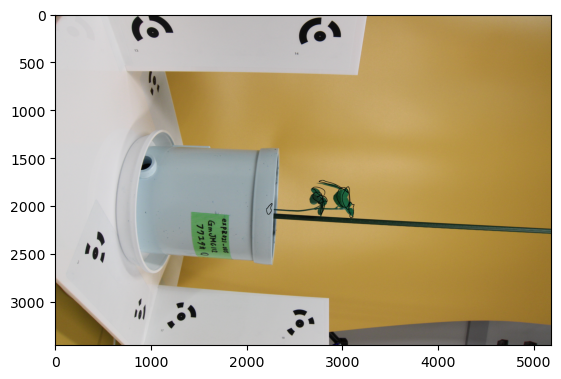

In [143]:
plt.imshow(ori_img)

In [3]:
df_list = []
for i, coord in enumerate(mc):
    df_tmp = pd.DataFrame(coord, columns=["x", "y", "z"])
    df_tmp["leaf_id"] = i
    df_list.append(df_tmp.copy())

df_curves = pd.concat(df_list)
df_curves = df_curves[["leaf_id", "x", "y", "z"]]
df_curves

,leaf_id,x,y,z
0,0,-0.153786,0.604596,-1.947434
1,0,-0.153710,0.604835,-1.947413
2,0,-0.153646,0.605054,-1.947374
3,0,-0.153594,0.605255,-1.947318
4,0,-0.153552,0.605438,-1.947246
...,...,...,...,...
355,7,-0.216191,0.453184,-1.908139
356,7,-0.216734,0.452890,-1.908008
357,7,-0.217280,0.452600,-1.907872
358,7,-0.217829,0.452315,-1.907730


In [6]:
v_file_pathes = glob.glob(view_mat_folder+"[0-9]*csv")
points = []
orientations = []
for path in v_file_pathes:
    Rt = np.loadtxt(path, delimiter=",")
    Rt = np.linalg.pinv(Rt)
    center = -np.dot(Rt[0:3, 0:3].T, Rt[0:3, 3])
    #Rt[0:3, 0:3]
    points.append(center)
    temp_ori = np.linalg.pinv(Rt) @ np.array([0,0,-1,1])
    orientations.append(temp_ori)

orientations = np.array(orientations)
orientations = np.array([orientations[:,0]/orientations[:,3], orientations[:,1]/orientations[:,3], orientations[:,2]/orientations[:,3]])
orientations = orientations.T
points = np.array(points)
df_pt = pd.DataFrame(points, columns=["x", "y", "z"])
df_pt["leaf_id"] = 9
df_pt = df_pt[["leaf_id", "x", "y", "z"]]

df_ori = pd.DataFrame(orientations, columns=["x", "y", "z"])
df_ori["leaf_id"] = 10
df_ori = df_ori[["leaf_id", "x", "y", "z"]]

df_m = pd.concat([df_pt, df_curves, df_ori])

In [7]:
point_cloud_path = "../preprocessing/polygon/exp2021_005_GmJMC112_01_MVI_01/exp2021_005_GmJMC112_01_MVI_01_ds.pcd"
pcd_load = o3d.io.read_point_cloud(point_cloud_path)
geo = []
geo.append(pcd_load)

In [8]:
o3d.visualization.draw_geometries(geo)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 要求された変換操作はサポートされていません。 
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [3]:
o3d.visualization.webrtc_server.enable_webrtc()

for j in range(len(mc)):
    points = mc[j]
    lines = [[i,i+1] for i in range(len(points)-1)]
    colors = [np.array([0,255,0])/255 for i in range(len(lines))]


    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)

    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = "unlitLine"
    mat.line_width = 10
    geo.append(line_set)
#geo.append(mat)
#o3d.visualization.draw({
#    "name": "lines",
#    "geometry": line_set,
#    "material": mat
#})



NameError: name 'mc' is not defined

In [23]:
-cam[0]

-0.08512238771301239

In [25]:
#for i in range(len(mc)):
#    x = mc[i][:,0]
#    y = mc[i][:,1]
#    z = mc[i][:,2]
#    mlab.plot3d(x, y, z, tube_radius=0.0005)

#mlab.points3d(points[:,0],points[:,1],points[:,2], (np.arange(len(points[:,2]))+1)/len(points[:,2]))
#mlab.points3d(orientations[:,0],orientations[:,1],orientations[:,2], (np.arange(len(points[:,2]))+1)/len(points[:,2]))
#mlab.view(azimuth=0, elevation=0, roll=0, reset_roll=False)
cam, foc = mlab.move()
mlab.view(focalpoint=cam+1)

print(cam)
mlab.move(-cam)

#mlab.move(np.array([1,1,1]))#位置
#mlab.view(focalpoint=points[0]-orientations[0])#向き

print(mlab.move())

mlab.show()

[ 0.08512239  0.85273614 -1.59778991]
(array([ 1.34717376,  2.55796953, -1.30736839]), array([ 1.13426782,  2.34506359, -1.52027434]))


In [27]:
def fig_save(center, orientation, output):
    fig = px.scatter_3d(
        df_m,
        x="x",
        y="y",
        z="z",
        #color="leaf_id",
        #template  = "simple_white",
    )
    fig.update_traces(
        marker=dict(size=1),

    )


    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0), 
        scene={"aspectmode":"data", 
                'xaxis':{"visible": False,},
                'yaxis':{"visible": False,},
                'zaxis':{"visible": False,}},
    )
    fig.update_coloraxes(showscale=False)

    fig.update_scenes(camera={"center": center,
                              "eye": orientation,})
    pio.write_image(fig, "{}.png".format(output))

def point2dict(point):
    point = {"x": point[0],
         "y": point[1],
         "z": point[2],}
    return point

In [28]:
points

array([[-0.21837105,  0.45192722, -1.90794877],
       [-0.21884829,  0.45158019, -1.9076778 ],
       [-0.21934041,  0.45125524, -1.90742579],
       ...,
       [-0.21728046,  0.45260013, -1.9078718 ],
       [-0.21782919,  0.4523153 , -1.90773016],
       [-0.21838071,  0.45203517, -1.90758335]])

In [32]:
i = 1
fig = px.scatter_3d(
        df_curves,
        x="x",
        y="y",
        z="z",
        color="leaf_id",
        #template  = "simple_white",
    )
fig.update_traces(
        marker=dict(size=1),

    )


fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0), 
        scene={"aspectmode":"data", 
                'xaxis':{"visible": False,},
                'yaxis':{"visible": False,},
                'zaxis':{"visible": False,}},
    )
fig.update_coloraxes(showscale=False)

fig.update_scenes(camera={#"center": point2dict(orientations[i]),
                              "eye": point2dict(points[i]),
                          })
fig.show()

In [81]:
points[i]

array([-0.80973608,  1.33741057, -1.76818427])

In [10]:
center = point2dict(points[0])
orientation = point2dict(orientations[0])
output = "test"
fig_save(center, orientation, output)

In [ ]:
points[0]
orientations[0]

<IPython.core.display.Javascript object>


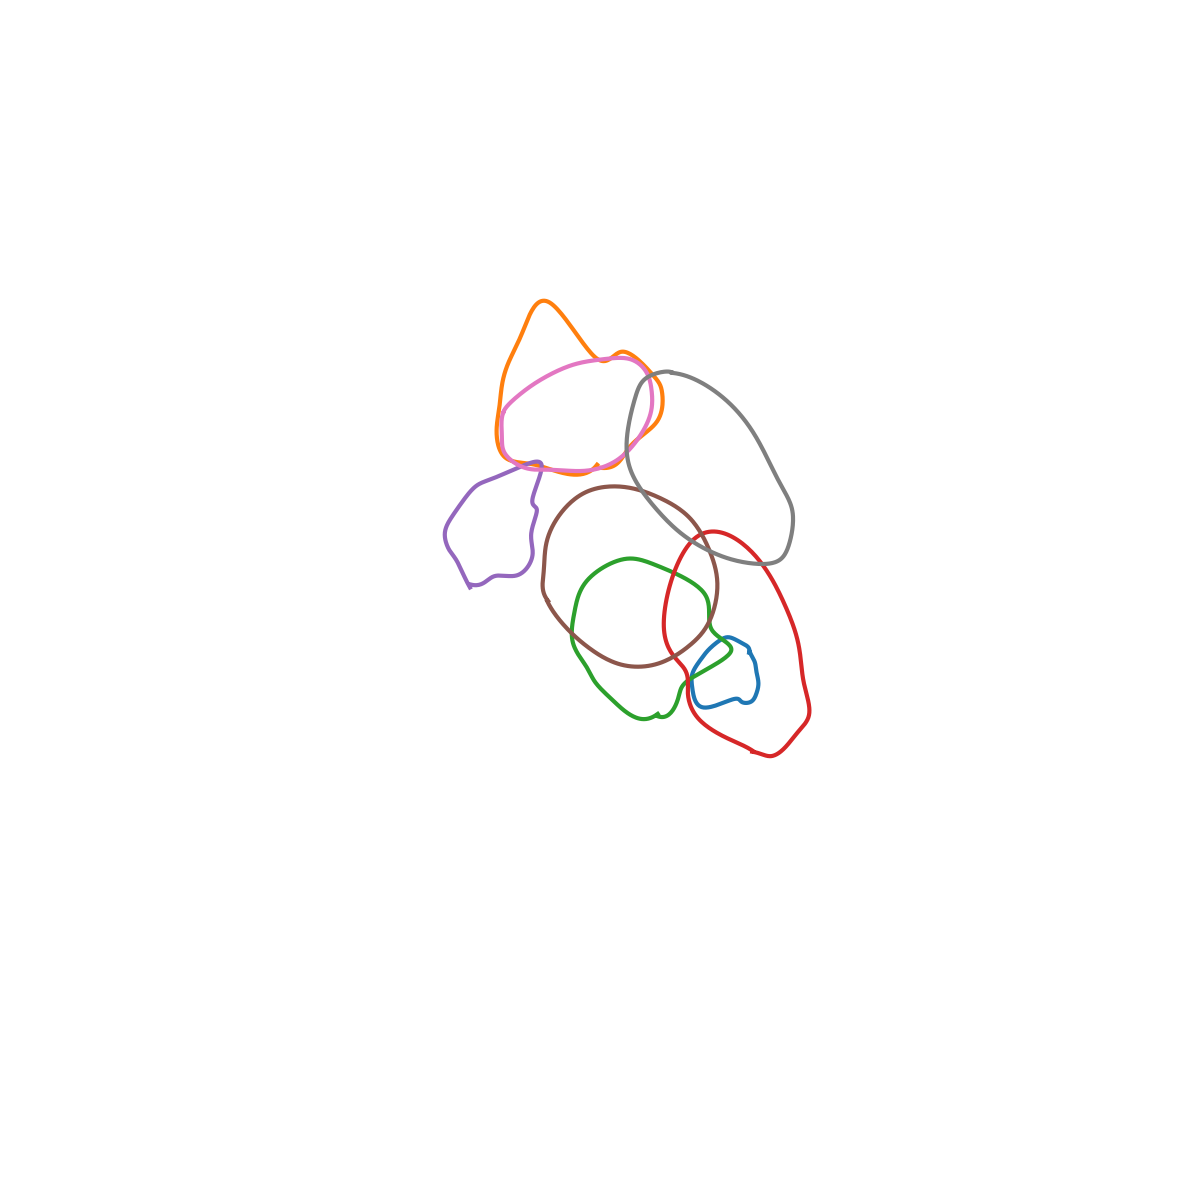

In [90]:
%matplotlib notebook
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))
ax.view_init(elev=-90, azim=0)

ax.axis("off")

for i in range(len(mc)):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(mc[i])
    pcd.rotate(np.linalg.inv(R),(0,0,0))
    pcd.rotate(R_mirror,(0,0,0))
    #pcd.scale(10,(0,0,0))
    s_c = np.array(pcd.points)
    x_q, y_q, z_q = s_c[:,0], s_c[:,1], s_c[:,2]
    ax.plot(x_q, y_q, z_q,"-",lw=3)#,color="#920092")
#plot_graph()



plt.show()